# Exploring Different Integration Methods
### Eli Orona

In Homework 1, we use both Euler and Runge-Kutta to integrate a differential equation. This example will explore the methods of integration in greater depth and how they compare to the analytical integration.

We will use the same dynamics as the homework, which luckily has a closed form solution.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

## ODE and Analytical Solution

In [2]:
def dynamic_unicycle_ode(state, control, time):
    x, y, theta, v = state
    omega, a = control
    return jnp.array([v * jnp.cos(theta), v * jnp.sin(theta), omega, a])

The analytical solution for this was solved using integration by parts. This specific solution knows that our initial state is all zero.

In [3]:
def numerical_integrator(dynamics, dt):
    def integrator(x, u, t):
        omega, a = control
        return jnp.array([
            a / (omega ** 2) * (omega * t * jnp.sin(2 * t) + jnp.cos(2 * t) - 1),
            a * (-t / omega * jnp.cos(omega * t) + 1 / (omega ** 2) * (jnp.sin(omega * t))),
            omega * t,
            a * t
        ])

    return integrator

## Integration Methods

Euler Integration: The simplest form. Take the current derivative and multiply it by dt. This projects the current "slope" out into the future blindly.

In [4]:
def euler_integrator(dynamics, dt):
    def integrator(x, u, t):
        x = x + dt * dynamics(x, u, t)
        return x

    return integrator

Runge-Kutta: By sampling multiple values for the derivative, a more accurate value can be found. The most common Runge-Kutta is the fourth-order method, but others exist that have more terms.

In [5]:
def runge_kutta_integrator(dynamics, dt=0.1):
    def integrator(x, u, t):
        k1 = dynamics(x, u, t)
        k2 = dynamics(x + 0.5 * dt * k1, u, t + dt / 2)
        k3 = dynamics(x + 0.5 * dt * k2, u, t + dt / 2)
        k4 = dynamics(x + dt * k3, u, t + dt)

        # Update next value of y
        x += (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        return x

    return integrator

## Comparisons

In [6]:
def simulate(dynamics, initial_state, controls, dt):
    states = [initial_state]

    t = 0
    for control in controls:
        states.append(dynamics(states[-1], control, t))
        t += dt

    return jnp.array(states)  # update this line

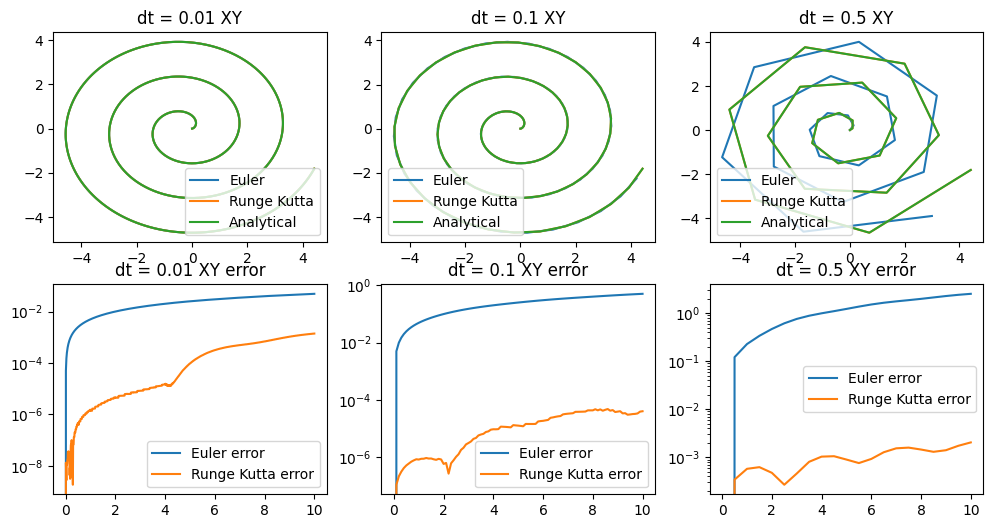

In [7]:
initial_state = jnp.array([0.0, 0.0, 0.0, 0.0])
control = jnp.array([2.0, 1.0])  # constant control over the 5 second duration.
duration = 10.0
dts = [0.01, 0.1, 0.5]
dynamics = {
    "Euler": lambda dynamic, dt: euler_integrator(dynamic, dt),
    "Runge Kutta": lambda dynamic, dt: runge_kutta_integrator(dynamic, dt),
    "Analytical": lambda dynamic, dt: numerical_integrator(dynamic, dt),
}

fig, axes = plt.subplots(nrows = 2, ncols=len(dts), figsize=(12, 6))
for i, dt in enumerate(dts):
    num_steps = int(duration / dt)
    dt_s = np.linspace(0, duration, num_steps + 1, endpoint=True)
    controls = [control] * num_steps

    outputs = {}
    for name, dyn in dynamics.items():
        discrete_dynamics = dyn(dynamic_unicycle_ode, dt)
        if name != "Analytical":
            xs = simulate(discrete_dynamics, initial_state, controls, dt)
        else:
            xs = jax.vmap(discrete_dynamics, in_axes=(None, None, 0))(initial_state, controls, dt_s)
        axes[0, i].plot(xs[:, 0], xs[:, 1], label=f"{name}")

        outputs[name] = xs

    axes[0, i].legend()
    axes[0, i].set_title(f"dt = {dt} XY")

    for name, dyn in dynamics.items():
        if name != "Analytical":
            xs = outputs[name]
            axes[1, i].semilogy(dt_s, jnp.linalg.norm(outputs["Analytical"] - xs, axis=1), label=f"{name} error")

    axes[1, i].legend()
    axes[1, i].set_title(f"dt = {dt} XY error")


## Conclusion

By simulating our system over a long period of time, we can see that the Euler method diverges more than Runge-Kutta, especially with larger dts. Also notice that the error plots are graphed in log, this is because the error from Runge-Kutta is over two orders of magnitude smaller, really highlighting its superiority over Euler. Another clear result is that the smaller the dt, the better our simulation, which is a logical conclusion.

The error is calculated by the distance between the analytical and iterative solutions, so the larger the error, the larger the divergence between the actual and simulated result.